<table style="width: 100%; border-collapse: collapse;" border="0">
<tr>
<td><b>Created:</b> Tuesday 7 August 2018</td>
<td style="text-align: right;"><a href="https://github.com/douglask3/savanna_fire_feedback_test">github.com/douglask3/savanna_fire_feedback_test</td>
</tr>
</table>

<div>
<center>
<font face="Times">
<br>
<h1>Quantifying the uncertainity in climate potentials and mortality using Bayesian inference</h1>
<h2>Part 3: Posterior sampling</h2>
<br>
<br>
<sup>1,* </sup>Douglas Kelley, 
<sup>1 </sup>France Gerard, 
<sup>2 </sup>Rhys Whitley, 
<sup>3 </sup>Elmar Veenendaal
<br>
<br>
<br>
<sup>1 </sup>Centre for Ecology and Hydrology, Maclean Building, Crowmarsh Gifford, Wallingford, Oxfordshire, United Kingdom
<br>
<sup>2 </sup>Natural Perils Pricing, Commercial & Consumer Portfolio & Pricing, Suncorp Group, Sydney, Australia
<br>
<sup>3 </sup>Wageningen Univsersity, Wageningen UR
<br>
<br>
<h3>Summary</h3>
<hr>
<p> 
This notebook aims to quantify the model parameters of a global tree cover model model. Tree Cover is calculated as a product  precipitation, tempurature  and radiation controls describing large scale climate potetials, and mortality from fire, seasonal drought, tempuature and people, and exlusion from land use modulate tree cover. This limitation model for tree cover (LimTREE) is optimized using a Bayesian Inference framework, which provides a probability distribution for the models paramters, and allows us to describe the magnitude and relative impact of controls and varaibles in terms of probabilities. Here, we cover model description and optimization.
</p>
<br>
<br>
<br>
<i>Python code and calculations below</i>
<br>
</font>
</center>
<hr>
</div>

In [53]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings('ignore')

import os
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv

import iris
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs
from   libs.plot_maps    import *
from scipy.stats import norm
from scipy.stats import skewnorm
from scipy.stats import lognorm
from pdb import set_trace as browser

def npLogit(x, n = None):
    if n is not None: x = (x*(n - 1) + 0.5) /n
    return np.log(x/(1.0-x))


# We're using the row which has minimum sigma
def newCubes3D(variable, step, eg_cube_in, dimname = 'model_level_number', minV = -10, maxV = None):
    def newCube(i):
        coord = iris.coords.AuxCoord(i, dimname)
        eg_cube = eg_cube_in.copy()
        eg_cube.data[eg_cube.data > 0.0] = 0.0
        try:
            eg_cube.remove_coord(dimname)
        except:
            pass
        eg_cube.add_aux_coord(coord)
        return(eg_cube)
    
    if not hasattr(step, '__len__'):
        
        if minV is None: minV = np.round(npLogit(np.min(eg_cube_in.data[eg_cube_in.data>0.0]))) #* 2.0
        if maxV is None: maxV = -minV#np.round(npLogit(np.max(eg_cube_in.data[eg_cube_in.data<1.0])))
        
        minV = minV - 1
        step = np.arange(minV ,maxV, step)     
    
    eg_cubes = iris.cube.CubeList([newCube(i) for i in step])
    eg_cubes = eg_cubes.merge()[0]
    
    return(eg_cubes)


In [54]:
dir = "../data/driving_Data/TROPICS/"
pr_datasets   = ['GPCC', 'CRU']#, 'MSWEP', 'CMORPH']: 
drought_vars  = ['MADD', 'MADM']#, 'MConc', 'MDDM']:
fire_datasets = ['GFED_four_s', 'GFED_four']

files = {'map'           : 'MAP_'        ,
         'mat'           : 'MAT.nc'      ,
         'sw1'           : 'SW1.nc'      ,
         'sw2'           : 'SW2.nc'      ,
         'burnt_area'    : 'BurntArea_'  ,
         'drought'       : ''            ,
         'maxTemp'       : 'MTWM.nc'     ,
         'wind'          : 'MaxWind.nc'  ,
         'pop_density'   : 'PopDen.nc'   ,
         'pasture_area'  : 'pas.nc'      ,
         'urban_area'    : 'urban.nc'    ,
         'crop_area'     : 'crop.nc'     ,
         'Tree_cover'    : 'TreeCover.nc'}


In [55]:
param_file = '../outputs/params-paper1-logitnorm-newPop-full-'
param_extensions = ['c1', 'c2']
title_output = 'attempt5'

In [56]:
##open data
def loadInputsParams(pr_dataset, drought_var, fire_dataset):
    print(pr_dataset)
    print(drought_var)
    print(fire_dataset)
    
    input_data = {}
    for key, file in files.items():
        if key == "map": file = file + pr_dataset + '.nc'
        if key == "drought": file = drought_var + '_' + pr_dataset + '.nc'
        if key == "burnt_area": file = file + fire_dataset + '.nc'
        data = iris.load_cube(dir + '/' + file)
        if key == "map": data.data = np.log(data.data)
        if key == "mat" or key == "maxTemp": data.data = np.log(data.data + 273.15)
        if key == "Tree_cover": 
            data.data /= 0.8
            data.data[data.data > 1.0] = 1.0
            data.data[data.data < 0.0] = np.nan
            
        input_data[key] = data
    
    params = [pd.read_csv(param_file + ext + '_' + pr_dataset + '_' + \
                          drought_var + '_' + fire_dataset +'.csv') for ext in param_extensions]
   
    if (len(params) >1):
        for p in params[1:]:
            params[0].append(p, ignore_index = True)
    
    params = params[0]
    return input_data, params
    
inputs = [[[loadInputsParams(pr, dr, fr) for pr in pr_datasets] for dr in drought_vars] for fr in fire_datasets]

GPCC
MADD
GFED_four_s
CRU
MADD
GFED_four_s
GPCC
MADM
GFED_four_s
CRU
MADM
GFED_four_s
GPCC
MADD
GFED_four
CRU
MADD
GFED_four
GPCC
MADM
GFED_four
CRU
MADM
GFED_four


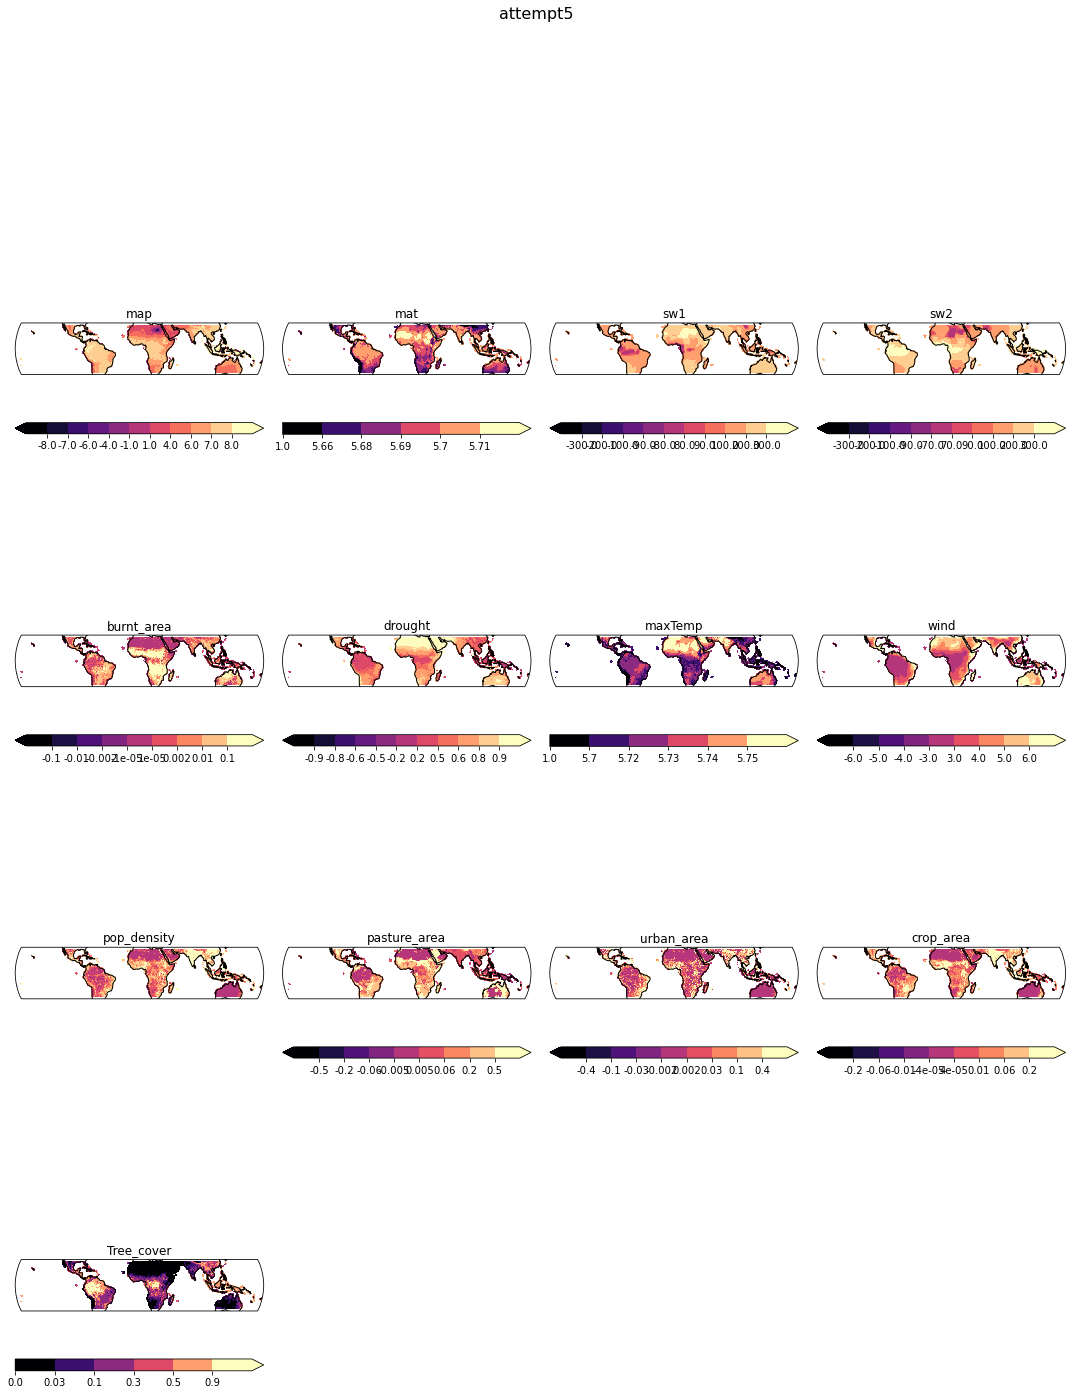

In [57]:
input_data = inputs[0][0][0][0]
nd = 0

plt.figure(figsize = (15, 20))

for key, dat in input_data.items():
    nd = nd + 1
    dat.long_name = key
    plot_lonely_cube(dat, 4, 4, nd, cmap = 'magma', levels = None)
    plt.suptitle(title_output, fontsize=16)
    plt.subplots_adjust(top=0.88)


In [58]:
class DeathCon(object):
    def __init__(self, data, params):
        """
        Initalise parameters and calculates the key variables needed to calculate burnt area.
        """
        self.params = params

        ## finds controls
        self.MAP = self.control_MAP(data['map'])
                                    
        self.MAT = self.control_MAT(data['mat'])
        
        self.SW = self.control_SW(data['sw1'], data['sw2'], self.params['trans_d'])       
        
                                    
        self.Mort = self.control_Mort(data['burnt_area'], data['drought'], data['maxTemp'], data['wind'],
                                      self.params['v_drought'], self.params['v_maxTemp'], 
                                      self.params['v_wind'],
                                      self.params['p_fire'], self.params['p_drought'])

        self.Exclude = self.control_Exclude(data['urban_area'], data['crop_area'], 
                                            data['pasture_area'], data['pop_density'], 
                                            self.params['v_crop'], self.params['v_pas'],
                                            self.params['v_popDen'], self.params['k_popden'])

        ## calculates limiting factor of each control.
        self.standard_MAP     = self.sigmoid(self.MAP,
                                             self.params['MAP_x0'], self.params['MAP_k'])  
        
        self.standard_MAT     = self.sigmoid(self.MAT,
                                            self.params['MAT_x0'], self.params['MAT_k']) 
        
        self.standard_SW      = self.sigmoid(self.SW,
                                            self.params['SW_x0'], self.params['SW_k']) 
        
        self.standard_Mort    = self.sigmoid(self.Mort,
                                            self.params['mort_x0'], -self.params['mort_k']) 
        
        self.standard_Exclude = self.sigmoid(self.Exclude,
                                            self.params['ex_x0'], -self.params['ex_k'])
                                                                           
        self.standard_Energy = self.standard_MAT * self.standard_SW
        self.error = self.params['sigma']
        ## burnt area us just limitation of each control muliplied together.
        self.Tree_cover_mode = self.standard_MAP * self.standard_MAT * self.standard_SW * \
            self.standard_Mort * self.standard_Exclude# * self.params['max_T']
        
        ## find the mean burnt area
        self.Tree_cover_calPDF(data)
        
        self.Tree_cover = self.Tree_cover_mean.copy() #* (1.0-self.p0)
        
        #browser()
        
        #self.standard_MAT    = self.standard_MAT / self.sigmoid(0.0, self.params['MAT_x0'],
        #                                         -self.params['MAT_k'])
        #self.standard_suppression = self.standard_suppression / self.sigmoid(0.0, self.params['suppression_x0'],
        #                                         -self.params['suppression_k'])

        self.potential_MAP = self.potential(self.standard_MAP, "potential_MAP")
        self.potential_MAT = self.potential(self.standard_MAT, "potential_MAT")
        self.potential_SW = self.potential(self.standard_SW, "potential_SW")
        self.potential_Mort = self.potential(self.standard_Mort, "potential_Mortality")
        self.potential_Exclude = self.potential(self.standard_Exclude, "potential_Exclude")
        self.potential_Energy = self.potential(self.standard_Mort, "potential_Energy")
        
        self.sensitivity_MAP = self.sensitivity(self.MAP, self.params['MAP_x0'], self.params['MAP_k'],
                                    self.standard_MAP, "sensitivity_MAP")

        self.sensitivity_MAT = self.sensitivity(self.MAT, self.params['MAT_x0'], -self.params['MAT_k'],
                                    self.standard_MAT, "sensitivity_MAT")

        self.sensitivity_SW = self.sensitivity(self.SW, self.params['SW_x0'], -self.params['SW_k'],
                                    self.standard_SW, "sensitivity_SW")

        self.sensitivity_Exclude = self.sensitivity(self.Exclude, self.params['ex_x0'], self.params['ex_k'],
                                    self.standard_Exclude, "sensitivity_Exclude")


        self.sensitivity_Mort = self.sensitivity(self.Mort, self.params['mort_x0'], -self.params['mort_k'] ,
                                    self.standard_Mort, "sensitivity_Mortality")

        

        self.sensitivity_Energy = self.sensitivity([self.MAT, self.SW], 
                                                   [self.params['MAT_x0'], self.params['SW_x0']],
                                                    [self.params['SW_k'], self.params['SW_k']],
                                                   self.standard_Energy, "sensitivity_Energy")
        ## if the inputs are iris cubes, we can add some useful metadata
        
        self.Tree_cover.long_name = "Tree_cover"
        self.Tree_cover_mode.long_name = "Tree_cover_mode"
        #self.burnt_area_median.long_name = "burnt_area_median"
        self.Tree_cover_mean.long_name = "Tree_cover_mean"

        self.MAP.long_name = "map"
        self.MAP.units = 'no_unit'

        self.MAT.long_name = "mat"
        self.MAT.units = 'no_unit'

        self.SW.long_name = "sw"
        self.SW.units = 'W m-2'

        self.Mort.long_name = "Mortality"
        self.Mort.units = '1'

        self.Exclude.long_name = "Exclude"
        self.Exclude.units = '1'

        self.standard_MAP.long_name     = "standard_MAP"
        self.standard_MAT.long_name     = "standard_MAT"
        self.standard_SW.long_name      = "standard_SW"
        self.standard_Mort.long_name    = "standard_Mortality"
        self.standard_Exclude.long_name = "standard_Exclude"
        self.standard_Energy.long_name  = "standard_Energy"

        self.standard_MAP.units     = '1'
        self.standard_MAT.units     = '1'
        self.standard_SW.units      = '1'
        self.standard_Mort.units    = '1'
        self.standard_Exclude.units = '1'
        self.standard_Energy.units  = '1'
      

    def control_MAP(self, map):
        """
        Definition to describe precip: while we are just returning input for now,
        we include climate potential functions for capability to be modified later.
        """
        out = map.copy()* 1
        return out


    def control_MAT(self, mat):#, min_mat, max_mat):
        """
        Definition to describe temp.
        """
        #mat = mat - min_mat
        #mat = mat / (max_mat - min_mat)
        #mat = tt.clip(mat, 0.0000001, 100000)
        #mat = tt.log(mat)
        out = mat.copy() * 1
        
        return out


    def control_SW(self, sw1, sw2, d):
        """
        Definition to describe short wave
        """
        return sw1 + d * sw2 /(1.0 + d)


    def control_Mort(self, fire, drought, maxTemp, wind, v_drought, v_maxTemp, v_wind,
                     p_fire, p_drought):#, min_maxTemp, max_maxTemp, p_maxTemp):
        """
        Definition of mortality
        """
        #maxTemp = maxTemp - min_maxTemp
        #maxTemp = maxTemp / (max_maxTemp - min_maxTemp)
        #maxTemp = tt.clip(maxTemp, 0.0, 1.0)
        #maxTemp = maxTemp **(p_maxTemp)

        drought = drought.copy() ** (p_drought)

        fire = fire.copy()**(p_fire)
        mort = fire  +  v_drought * drought  +  v_maxTemp * maxTemp  + v_wind * wind

        return mort / (1.0 + v_drought + v_maxTemp + v_wind)

    def control_Exclude(self, urban_area, crop_area, pasture_area, pop_density, v_crop, v_pas, v_pop, k_popden):
        """
        Definition for the measure of fire supression
        """
        pop_density = pop_density.copy()
        pop_density.data = 1 - np.exp(pop_density.data * (-1.0/ k_popden))
        excl = urban_area  +  v_crop * crop_area + v_pas * pasture_area + v_pop * pop_density 

        return excl / (1.0 + v_crop + v_pas + v_pop)



    def sensitivity(self, x, x0, k, fi, long_name = None):
        
        if type(x) is list:
            gradients = [self.gradient(xi, x0i, ki) for xi, x0i, ki in zip(x, x0, k)]
            gradient = gradients[0]
            for g in gradients[1:]: gradient *= gradient
            
            gradient.data = gradient.data**len(gradients)            
        else:
            gradient = self.gradient(x, x0, k)
            
        if type(fi) is list:
            fis = fi.copy()
            fi = fis[0]
            for f in fis: fi *= f
                
            fi.data = fi.data**len(fis)
            
        sens = gradient * self.control_removal(fi)

        try: sens.units = '1'
        except: pass

        if long_name is not None:
            try: sens.long_name = long_name
            except: browser()
        return sens


    def control_removal(self, fi):
        return self.Tree_cover_mode/fi


    def potential(self, fi, long_name = None):
        out = fi.copy()
        out.data = self.Tree_cover_mode.data * ((1/out.data) - 1)

        try: out.units = '1'
        except: pass

        if long_name is not None:
            try: out.long_name = long_name
            except: pass
        return out


    def gradient(self, x, x0, k, dx = 0.0001):

        f1 = self.sigmoid(x + dx, x0, k)
        f2 = self.sigmoid(x - dx, x0, k)

        n1 = self.sigmoid(x0 + dx, x0, k)
        n2 = self.sigmoid(x0 - dx, x0, k)

        try:
            f1 = (f1 - f2)/(n1 - n2)
        except:
            f1.data = (f1.data - f2.data) / (n1.data - n2.data)

        return f1


    def sigmoid(self, x, x0,k):
        """
        Sigmoid function to describe limitation using tensor
        """
        try:
            out = x.copy()
            out.data = -k*(x.data - x0)
            out.data = 1.0/(1.0 + np.exp(out.data))
            x = out
        except:
            x = -k * (x - x0)
            x = 1.0/(1.0 + np.exp(x))
        return x
    
    def Tree_cover_calPDF(self, data):
        
        mask = np.logical_not(self.Tree_cover_mode.data.mask)
        self.Tree_cover_pdf = newCubes3D('Tree_cover', 0.5,
                                         data['Tree_cover'])
        
        self.Tree_cover_mean = self.Tree_cover_mode.copy()
        self.Tree_cover_mean.data[mask] = 0.0
        
        level_no = self.Tree_cover_pdf.coord('model_level_number').points
        
        dist = norm(npLogit(self.Tree_cover_mode.data[mask]), self.error)
        
        x = self.Tree_cover_pdf.coord('model_level_number').points
        for k in range(1, self.Tree_cover_pdf.shape[0]):       
            self.Tree_cover_pdf.data[k][mask] = dist.pdf(x[k])
            self.Tree_cover_mean.data[mask]  = self.Tree_cover_mean.data[mask] +  dist.pdf(x[k]) *(1/(1+np.exp(-x[k])))
                                     
        PDFtot = self.Tree_cover_pdf.collapsed(['model_level_number'], iris.analysis.SUM)
        
        self.Tree_cover_mean.data = self.Tree_cover_mean.data/ PDFtot.data
        
    def Prob_beta_given_Tree_cover(self, TC):
        mask = ~np.isnan(TC.data) * ~self.Tree_cover_mode.data.mask        
        ncells = np.sum(mask)
        mu = npLogit(TC.data[mask], ncells) - npLogit(self.Tree_cover_mode.data[mask], ncells)
        
        sigma = self.params['sigma']
        prob = - np.log(sigma * np.sqrt(2.0 * math.pi)) - np.mean(mu**2.0)/(2.0*sigma**2.0)
        return np.exp(prob)
        
        

In [59]:
def bootSamples(x, samples, nsample = 2):
    def bootSamples(x):
        #browser()or np.ma.is_masked(test)
        test = np.ma.sum(x)
        
        out = np.repeat(0, nsample)
        if test==0 : return out
        try:
            out = np.random.choice(samples, nsample, p =x/np.sum(x))
        except:
            out = np.repeat(0, nsample)
        return out
    x = np.apply_along_axis(bootSample, 0, x)
    return(x)



In [60]:
def runModelExperiment(input, paramLoc = None):
    
    input_data = input[0]
    params = input[1]
    #browser()
    if paramLoc is None: paramLoc = params["sigma"].idxmin()
    print("running")    
    
    model = DeathCon(input_data, params.loc[paramLoc])
    #model.Prob_beta_given_Tree_cover(inputs[0][0][0][0]['Tree_cover'])
    return model
    PDF = model.Tree_cover_pdf.data
    
    mask = PDF[0,:,:].mask == False
    TCs = model.Tree_cover_pdf.coord("model_level_number").points
    TCs = 1/(1+np.exp(-BAs))

    PDF = bootSamples(PDF[:,mask], TCs, 10)

    
    model_out.Tree_cover_pdf.data[:] = 0.0
    
    def posterize(i): return np.argmin(np.abs(i-TCs))
    vpost = np.vectorize(posterize)
    PDF_out = vpost(PDF_out)
    for PDF in PDF_out:
        for i in np.unique(PDF):
            test = PDF == i
            try:
                model_out.Tree_cover_pdf.data[i][mask] =+ test
            except:
                browser()
            
           
    return model_out
models = [[[runModelExperiment(input) for input in i] for i in j] for j in inputs]

running
running
running
running
running
running
running
running


### Tree Cover plot

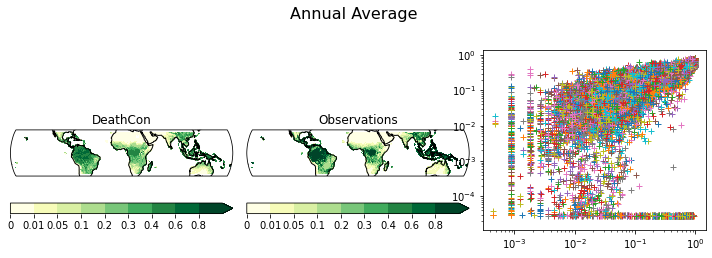

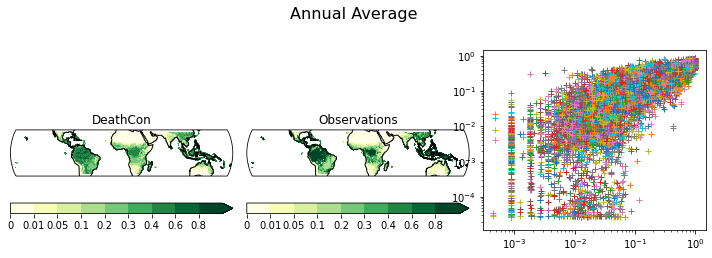

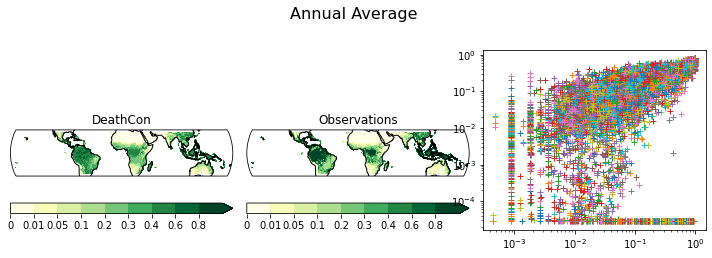

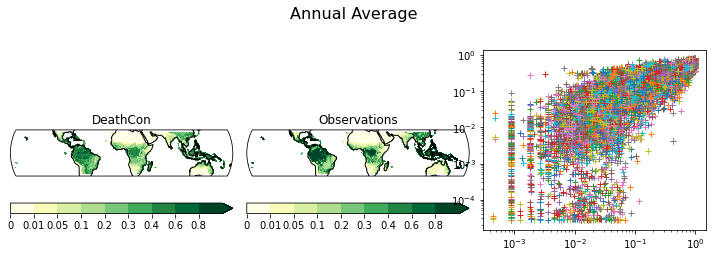

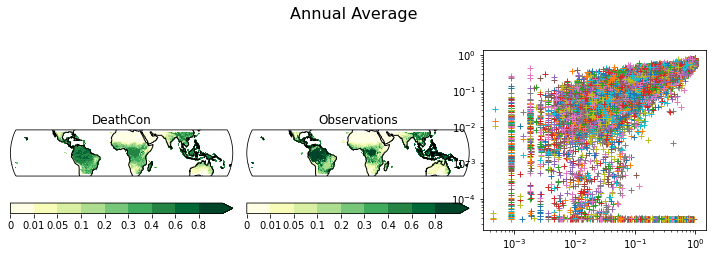

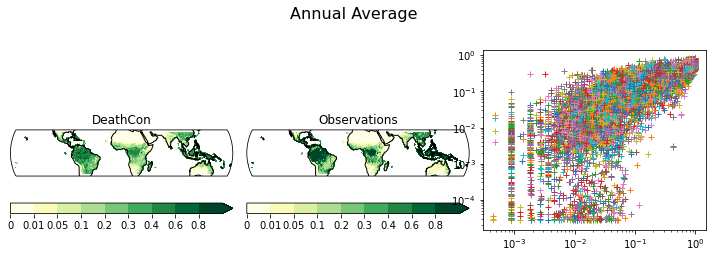

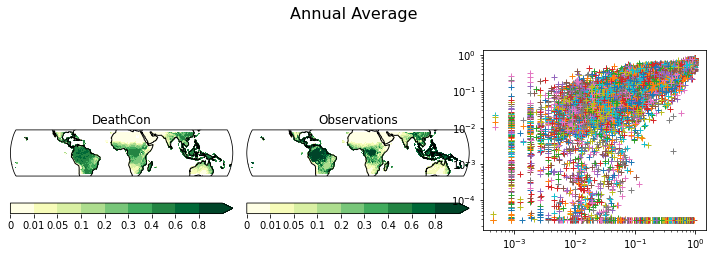

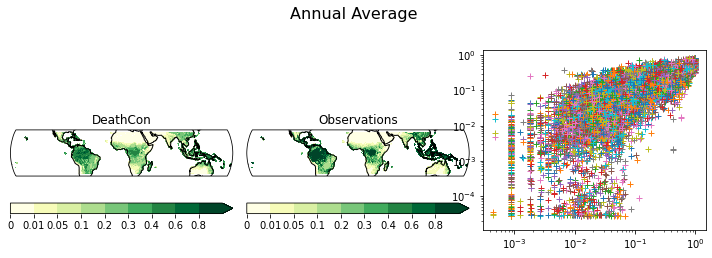

In [61]:
def plot_model_Tree_cover(model, level, addObs = False, 
                          figsize = (10, 6), Title = "Annual Average ", N = 2, M = 3, n = 0, 
                          addScatter = False, *args, **kw):
    if figsize is not None: plt.figure(figsize = figsize)
    
    sim = model.Tree_cover_mean    
    sim.long_name = "DeathCon"
    plot_lonely_cube(sim, N, M, n + 1, levels = level, cmap = "brewer_YlGn_09", *args, **kw)
    
    obs = inputs[0][0][0][0]["Tree_cover"]
    if addObs:
        obs.long_name = "Observations"
        plot_lonely_cube(obs, N, M, n + 2, levels = level, cmap = "brewer_YlGn_09", *args, **kw)
    
    if addScatter:
        plt.subplot(N, M, n + 3)
        plt.plot(obs.data, sim.data, '+')
        plt.gca().set_yscale('log')
        plt.gca().set_xscale('log')
    plt.subplots_adjust(top=0.88)
    plt.suptitle(Title, fontsize=16)
    plt.subplots_adjust(top=0.88)

            
clevels = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8]


    
for model in models: 
    for mod in model: 
        for m in mod:
            plot_model_Tree_cover(m, clevels, extend = 'max', addObs = True, addScatter = True)
    
#plot_lonely_cube(model[0],[1], N, M, n + 1, levels = level, cmap = "brewer_YlOrRd_09", extend = 'max')

### Controls plot

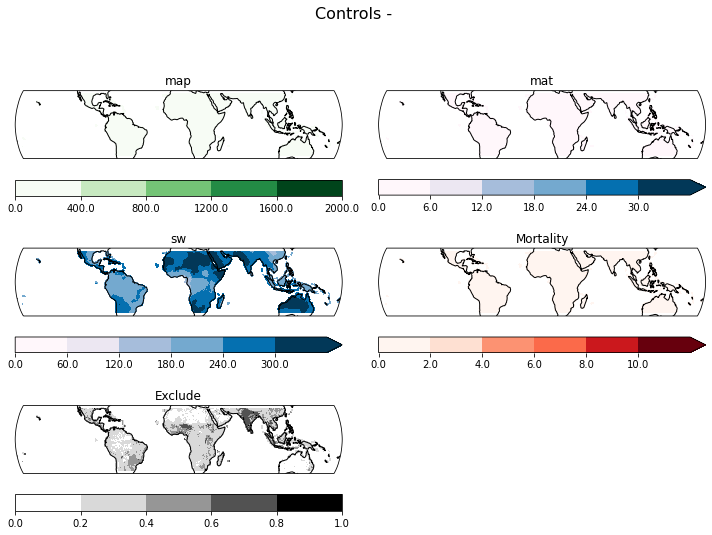

In [62]:
cmap_MAP = 'brewer_Greens_09'
cmap_Energy = 'brewer_PuBu_09'
cmap_Mortality = 'brewer_Reds_09'
cmap_Exclusion= 'brewer_Greys_09'

levels_frac = np.array([0,0.2, 0.4, 0.6,  0.8,  1.0])
#levels_frac = [0,0.45,  0.5, 0.55, 1.0]
#levels_ignitions = np.array([0, 100, 200,500, 1000, 2000, 5000])/5000.0
#levels_moisture = [0, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
    
def plotModComponet(comp, n, name = None, levels = None, scale = None, cmap = "brewer_YlOrRd_09",
                    N = 3, M = 2, *args, **kws):
    
    #comp = comp[mnths].collapsed('time', iris.analysis.MEAN)
    if name  is not None: comp.long_name = name
    plot_lonely_cube(comp, N, M, n, levels = levels, cmap = cmap, *args, **kws)


def plot_fire_month(model, Title = '',  **kw):    
    plt.figure(figsize = (10, 7.5))
    model = model
    plotModComponet(model.MAP, 1, cmap = cmap_MAP, levels = levels_frac*2000, **kw)
    plotModComponet(model.MAT, 2, cmap = cmap_Energy, levels = levels_frac*30, extend = 'max', **kw)
    plotModComponet(model.SW, 3, cmap = cmap_Energy, levels = levels_frac*300, extend = 'max', **kw)
    plotModComponet(model.Mort, 4, cmap = cmap_Mortality, levels = levels_frac*10, extend = 'max', **kw)
    plotModComponet(model.Exclude, 5, cmap = cmap_Exclusion, levels = levels_frac, **kw)
    plt.suptitle('Controls - ' + Title, fontsize=16)
    plt.subplots_adjust(top=0.88)
    
            
plot_fire_month(models[0][1][0])

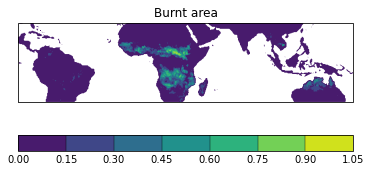

In [63]:
qplt.contourf(inputs[0][0][0][0]["burnt_area"])

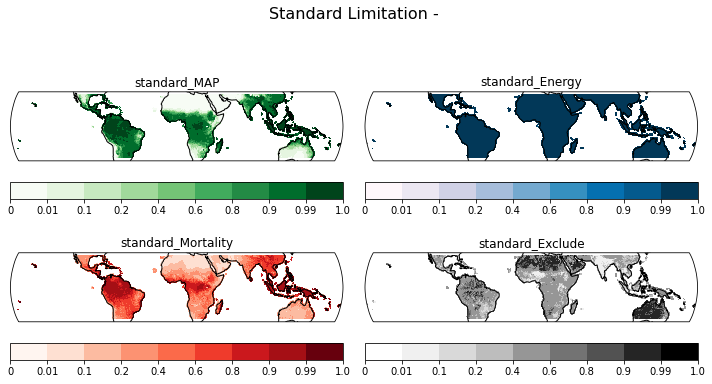

In [64]:
levels = [0, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.99, 1.0]
#levels = [0, 0.01, 0.02, 0.05, 0.1, 0.2,  0.5]
def plot_fire_month(model, **kw):
    
    plt.figure(figsize = (10, 7.5))
    plotModComponet(model.standard_MAP, 1, cmap = cmap_MAP, levels = levels, **kw)
    plotModComponet(model.standard_Energy, 2, cmap = cmap_Energy, levels = levels, **kw)
    plotModComponet(model.standard_Mort, 3, cmap = cmap_Mortality, levels = levels, **kw)
    plotModComponet(model.standard_Exclude, 4, cmap = cmap_Exclusion, levels = levels, **kw)
    plt.suptitle('Standard Limitation - ', fontsize=16)
    plt.subplots_adjust(top=0.88)
            
plot_fire_month(models[0][0][0])

### Bootstrapping Postieor
So, thats all been looking at just one, albiet very likely parameter combination. The really useful thing about this framework is the uncertainty in the parameters. I'll probably add some visulaisation of that here at some point, but the main thing is to sample the postiror so you can go away and do you own analysis. 

First off some switches. Which things do you want to get a sample for?:

* ```output_controls``` for fuel, moistire, igntions and sepression
* ```output_<<<xxx>>``` output the <<xxx>> type of limitation or sensitivity.

The more you have switched on, the long it takes. But the more cool results you'll have!

In [65]:
output_controls = True
output_standard_limitation = True
output_potential_limitation = True
output_sensitivity = True
output_fullPost = True

Next we have the number of parameter combinations we want to sample (```n_posterior_sample```) - the more the better detail but the longer the time. ```step``` is descibed the sampling gap for the paramater combination + error. The unit is fractional burnt area. The small the step, the more detailed you overall postiror (i.e P(fire| (B | Obs)), but the slower. You might not need P(fire| (B | Obs). In which case, set this to ```None``` and enjoy the extra quick processing time!

```qs``` is the percentiles we'll use to summerise the prbablity density curves at the end. I just set this to 1-99% at 1% intervals... might be overkill (maybe you just need 1, 5, 10, 25, 50, 75, 90, 95, 99 for example). But its so quick compared to everything else, that I'd rather set this detailed so I dont have to rerun.

Finally, we set a directory to stick a load of outputs we're about to generate

In [66]:
n_posterior_sample = 3

qs = np.arange(1, 100, 1)
output_dir = '../data/sampled_posterior/'

TCs = models[0][0][0].Tree_cover_pdf.coord("model_level_number").points
TCs = 1/(1+np.exp(-TCs))

In [67]:
def weighted_percentile(data, percents, weights=None):
    ''' percents in units of 1%
        weights specifies the frequency (count) of data.
    '''
    if weights is None:
        return np.percentile(data, percents)
    ind=np.argsort(data)
    d=data[ind]
    w=weights[ind]
    p=1.*w.cumsum()/w.sum()*100
    y=np.interp(percents, p, d)
    return y

In [68]:
def mkDir(dir):
    try: os.mkdir(dir)  
    except: pass

In [69]:
mkDir(output_dir)

output_diri = output_dir + title_output +'/'
mkDir(output_diri)


In [70]:
def input4Experiment(input, exp):
    exp = exp[1:]
    if len(exp) == 0: return input
    for expi in exp:
        newdat = input[0][expi[0]].copy()
        if not isinstance(expi, str):
            newdat.data[:] = expi[1]
        else:
            browser()
        input[0][expi[0]] = newdat
        
    return input

In [71]:
def summary_cubes(tree_outi, dir):
    tree_out = []
    for i in range(len(iris.load(tree_outi[0]))):
        outi = []
        for file in tree_outi:
            out = iris.load(file)
            outi = outi + [out[i].data]

        percentile_cube = newCubes3D("Tree_cover", qs, out[i]) 
        percentile_cube.data = np.percentile(np.array(outi), qs, 0)

        tree_out = tree_out + [percentile_cube]
            
    outFile = dir + 'model_summary.nc'
    tree_out = iris.cube.CubeList(tree_out) 
    print(outFile)
    iris.save(tree_out, outFile) 
    return tree_out
    

In [72]:
def bootModel(input, fr, dr, pr, exp, p_betaY_in = None):
    output_dirii = output_diri + '/' + exp[0] + '/'
    mkDir(output_dirii)
    
    output_diriii = output_dirii + '/' + fr + '_' + dr + '_' + pr + '/'
    mkDir(output_diriii)
    
    input = input4Experiment(input, exp)
    
    tree_outi = []
    outfiles = []
    
    n_posterior = input[1].shape[0]
    ngap = int(n_posterior/n_posterior_sample)    
    en = 0
    ens_ids = range(0, n_posterior, ngap)
    
    if ngap == 0: ngap = 1
    if p_betaY_in is None :
        p_betaY = np.repeat(0.0, len(ens_ids))
    else:
        p_betaY = p_betaY_in
    for i in ens_ids:
        model = runModelExperiment(input, i)        
        
        #model = ConFIRE(input_data, params.iloc[i])
        Tree_cover = model.Tree_cover_mean
        cubes = [model.Tree_cover_mean]
        if output_fullPost:
            if i == 0:
                fullPost = model.Tree_cover_pdf
            else:
                fullPost = fullPost + model.Tree_cover_pdf   

        if output_controls:
            cubes = cubes + [model.MAP, model.MAT, 
                             model.SW, model.Mort, model.Exclude]
        
        if output_standard_limitation:
            cubes = cubes + [model.standard_MAP, model.standard_MAT, model.standard_SW, 
                             model.standard_Mort, model.standard_Exclude, model.standard_Energy] 

        if output_potential_limitation:
            cubes = cubes + [model.potential_MAP, model.potential_MAT, model.potential_SW, 
                             model.potential_Mort, model.potential_Exclude, model.potential_Energy]
                             

        if output_sensitivity:
            cubes = cubes + [model.sensitivity_MAP, model.sensitivity_MAT, model.sensitivity_SW, 
                             model.sensitivity_Mort, model.sensitivity_Exclude, model.sensitivity_Energy]
        
        cubes = iris.cube.CubeList(cubes) 
        if i == 0:
            fullPDF = model.Tree_cover_pdf.copy()
        else:
            fullPDF.data =+ model.Tree_cover_pdf.data
        #tree_outi = tree_outi + [cubes]
        outFile = output_diriii + 'sample_no_' + str(i) +'.nc'
        print(outFile)
        outfiles.append(outFile)
        iris.save(cubes, outFile)
        #browser()
        if p_betaY_in is None:
            print(en)
            p_betaY[en] = model.Prob_beta_given_Tree_cover(input[0]['Tree_cover'])
            en += 1
    
    tree_out = summary_cubes(outfiles, output_diriii)
    
    outFile = output_diriii + 'fullPost.nc'
    print(outFile)
    iris.save(fullPost, outFile) 
    
    pInfo = pd.DataFrame(np.vstack((np.array(ens_ids), p_betaY)).T)
    pInfo.columns = ['Ensemble no.', 'P given TC']
    pInfo.to_csv(output_diriii + 'Prob_info.csv')
    
    return outfiles, p_betaY
        
#for model, i in zip(model_names, inputs):
#model = model_names[0]
#inputs = inputs[0]
#for experiment, input in zip(experiments, i):
#    print(model)
#    bootModel(input, model, experiment)


#inputs = [[[loadInputsParams(pr, dr, fr) for pr in pr_datasets] for dr in drought_vars] for fr in fire_datasets]
#models = [[[runModelExperiment(input) for input in i] for i in j] for j in inputs]

In [ ]:
experiment = [["control",                                                                        ],
              ["noMAP"      , ["map"         , 99.9]                                             ],
              ["noMAT"      , ["mat"         , 99.9]                                             ],
              ["noNoneMAT"  , ["mat"         , 99.9], ["maxTemp"     , 0.0], ["drought", 0.0],
                              ["sw1"         ,  0.0], ["sw2"         , 0.0], ["wind"   , 0.0]    ],
              ["noFire"     , ["burnt_area"  ,  0.0]                                             ],
              ["noDrought"  , ["drought"     ,  0.0]                                             ],
              ["noTasMort"  , ["maxTemp"     ,  0.0]                                             ],
              ["noPop"      , ["pop_density" ,  0.0]                                             ],
              ["noUrban"    , ["urban_area"  ,  0.0]                                             ],
              ["noCrop"     , ["crop_area"   ,  0.0]                                             ],
              ["noPas"      , ["pasture_area",  0.0]                                             ],
              ["noHumans"   , ["pop_density" ,  0.0], ["urban_area"  ,  0.0], 
                              ["crop_area"   ,  0.0], ["pasture_area",  0.0]                     ],
              ["noExclusion", ["pasture_area",  0.0], ["urban_area"  ,  0.0], 
                              ["crop_area"   ,  0.0], ["pop_density" ,  0.0]                     ], 
              ["noMortality", ["maxTemp"     ,  0.0], ["drought"     ,  0.0],
                              ["burnt_area"  ,  0.0]                                             ]]

def runExp(exp, index = None, p_betaY_in = None):
    samples = []
    p_betaYs = []
    for fr, iii in zip(fire_datasets, inputs):
        for dr, ii in zip(drought_vars, iii):
            for pr, i in zip(pr_datasets, ii):
                sample, p_betaY = bootModel(i, fr, dr, pr, exp)
                samples.append(sample)
                p_betaYs.append(p_betaY)
            
    npsamples = np.array(samples).flatten()#reshape(-1,np.array(samples).shape[-1])
    npp_betaYs = np.array(p_betaYs).flatten()#.reshape(npsamples.shape[0])
    if index is None:
        index = np.random.choice(np.arange(0,len(npp_betaYs)), size = n_posterior_sample+1,  replace = True, p = npp_betaYs/np.sum(npp_betaYs))
    tree_outi = npsamples[index]
    
    output_dirii = output_diri + '/' + exp[0] + '/'
    mkDir(output_dirii)
    tree_out = summary_cubes(tree_outi, output_dirii)
    return samples, p_betaYs, index, tree_out

samples, p_betaYs, index, tree_out = runExp(experiment[0])  

for exp in experiment[1:]:                
    runExp(exp, index = index, p_betaY_in = p_betaYs)

running
../data/sampled_posterior/attempt5//control//GFED_four_s_MADD_GPCC/sample_no_0.nc
0
running
../data/sampled_posterior/attempt5//control//GFED_four_s_MADD_GPCC/sample_no_3333.nc
1
running
../data/sampled_posterior/attempt5//control//GFED_four_s_MADD_GPCC/sample_no_6666.nc
2
running
../data/sampled_posterior/attempt5//control//GFED_four_s_MADD_GPCC/sample_no_9999.nc
3
../data/sampled_posterior/attempt5//control//GFED_four_s_MADD_GPCC/model_summary.nc
../data/sampled_posterior/attempt5//control//GFED_four_s_MADD_GPCC/fullPost.nc
running
../data/sampled_posterior/attempt5//control//GFED_four_s_MADD_CRU/sample_no_0.nc
0
running
../data/sampled_posterior/attempt5//control//GFED_four_s_MADD_CRU/sample_no_3333.nc
1
running
../data/sampled_posterior/attempt5//control//GFED_four_s_MADD_CRU/sample_no_6666.nc
2
running
../data/sampled_posterior/attempt5//control//GFED_four_s_MADD_CRU/sample_no_9999.nc
3
../data/sampled_posterior/attempt5//control//GFED_four_s_MADD_CRU/model_summary.nc
../d

2
running
../data/sampled_posterior/attempt5//noMAP//GFED_four_MADM_CRU/sample_no_9999.nc
3
../data/sampled_posterior/attempt5//noMAP//GFED_four_MADM_CRU/model_summary.nc
../data/sampled_posterior/attempt5//noMAP//GFED_four_MADM_CRU/fullPost.nc
../data/sampled_posterior/attempt5//noMAP/model_summary.nc
running
../data/sampled_posterior/attempt5//noMAT//GFED_four_s_MADD_GPCC/sample_no_0.nc
0
running
../data/sampled_posterior/attempt5//noMAT//GFED_four_s_MADD_GPCC/sample_no_3333.nc
1
running
../data/sampled_posterior/attempt5//noMAT//GFED_four_s_MADD_GPCC/sample_no_6666.nc
2
running
../data/sampled_posterior/attempt5//noMAT//GFED_four_s_MADD_GPCC/sample_no_9999.nc
3
../data/sampled_posterior/attempt5//noMAT//GFED_four_s_MADD_GPCC/model_summary.nc
../data/sampled_posterior/attempt5//noMAT//GFED_four_s_MADD_GPCC/fullPost.nc
running
../data/sampled_posterior/attempt5//noMAT//GFED_four_s_MADD_CRU/sample_no_0.nc
0
running
../data/sampled_posterior/attempt5//noMAT//GFED_four_s_MADD_CRU/sample_

../data/sampled_posterior/attempt5//noNoneMAT//GFED_four_MADM_GPCC/fullPost.nc
running
../data/sampled_posterior/attempt5//noNoneMAT//GFED_four_MADM_CRU/sample_no_0.nc
0
running
../data/sampled_posterior/attempt5//noNoneMAT//GFED_four_MADM_CRU/sample_no_3333.nc
1
running
../data/sampled_posterior/attempt5//noNoneMAT//GFED_four_MADM_CRU/sample_no_6666.nc
2
running
../data/sampled_posterior/attempt5//noNoneMAT//GFED_four_MADM_CRU/sample_no_9999.nc
3
../data/sampled_posterior/attempt5//noNoneMAT//GFED_four_MADM_CRU/model_summary.nc
../data/sampled_posterior/attempt5//noNoneMAT//GFED_four_MADM_CRU/fullPost.nc
../data/sampled_posterior/attempt5//noNoneMAT/model_summary.nc
running
../data/sampled_posterior/attempt5//noFire//GFED_four_s_MADD_GPCC/sample_no_0.nc
0
running
../data/sampled_posterior/attempt5//noFire//GFED_four_s_MADD_GPCC/sample_no_3333.nc
1
running
../data/sampled_posterior/attempt5//noFire//GFED_four_s_MADD_GPCC/sample_no_6666.nc
2
running
../data/sampled_posterior/attempt5//n

running
../data/sampled_posterior/attempt5//noDrought//GFED_four_MADM_GPCC/sample_no_0.nc
0
running
../data/sampled_posterior/attempt5//noDrought//GFED_four_MADM_GPCC/sample_no_3333.nc
1
running
../data/sampled_posterior/attempt5//noDrought//GFED_four_MADM_GPCC/sample_no_6666.nc
2
running
../data/sampled_posterior/attempt5//noDrought//GFED_four_MADM_GPCC/sample_no_9999.nc
3
../data/sampled_posterior/attempt5//noDrought//GFED_four_MADM_GPCC/model_summary.nc
../data/sampled_posterior/attempt5//noDrought//GFED_four_MADM_GPCC/fullPost.nc
running
../data/sampled_posterior/attempt5//noDrought//GFED_four_MADM_CRU/sample_no_0.nc
0
running
../data/sampled_posterior/attempt5//noDrought//GFED_four_MADM_CRU/sample_no_3333.nc
1
running
../data/sampled_posterior/attempt5//noDrought//GFED_four_MADM_CRU/sample_no_6666.nc
2
running
../data/sampled_posterior/attempt5//noDrought//GFED_four_MADM_CRU/sample_no_9999.nc
3
../data/sampled_posterior/attempt5//noDrought//GFED_four_MADM_CRU/model_summary.nc
../d

0
running
../data/sampled_posterior/attempt5//noPop//GFED_four_MADD_CRU/sample_no_3333.nc
1
running
../data/sampled_posterior/attempt5//noPop//GFED_four_MADD_CRU/sample_no_6666.nc
2
running
../data/sampled_posterior/attempt5//noPop//GFED_four_MADD_CRU/sample_no_9999.nc
3
../data/sampled_posterior/attempt5//noPop//GFED_four_MADD_CRU/model_summary.nc
../data/sampled_posterior/attempt5//noPop//GFED_four_MADD_CRU/fullPost.nc
running
../data/sampled_posterior/attempt5//noPop//GFED_four_MADM_GPCC/sample_no_0.nc
0
running
../data/sampled_posterior/attempt5//noPop//GFED_four_MADM_GPCC/sample_no_3333.nc
1
running
../data/sampled_posterior/attempt5//noPop//GFED_four_MADM_GPCC/sample_no_6666.nc
2
running
../data/sampled_posterior/attempt5//noPop//GFED_four_MADM_GPCC/sample_no_9999.nc
3
../data/sampled_posterior/attempt5//noPop//GFED_four_MADM_GPCC/model_summary.nc
